### Import the needed package

In [11]:
# package to get the custom modules
import sys
# package for handling the environment variables
from dotenv import load_dotenv

# add the path to the custom modules
sys.path.insert(0, './../')
# load the environment variables
load_dotenv()

# package for handling the files
import os
# package for handling random numbers
from random import randint
# package for handling array
import numpy as np
# package for handling the metadata and tabular data
import pandas as pd
from itertools import chain
# the custom module for handling the data
import utilities as utils
# package for handling the machine learning model
import tensorflow as tf

### Global variables

In [34]:
path_full = os.environ.get("ORI_PATH")
path_dataset_ori = os.path.join(path_full, "datasets", "splitted", "original", "test")
path_dataset_aug = os.path.join(path_full, "datasets", "splitted", "augmented", "test")
path_cdr_data = os.path.join(path_full, "data", "cdr_dataset.csv")
models_name = ["unet_model_ori", "unet_model_aug", "mnet_model_ori", "mnet_model_aug", "efnet_model_ori", "efnet_model_aug"]

### Get CDR value from the dataset

In [9]:
cdr_data = pd.read_csv(path_cdr_data)
cdr_data.head(5)

,id,label,eye_side,a_cdr,v_cdr,h_cdr
0,fff_0_111784_l_y_mask,0,l,0.340206,0.633803,0.560606
1,fff_0_111784_r_y_mask,0,r,0.300445,0.541667,0.538462
2,fff_0_113060_l_1_mask,0,l,0.473950,0.686275,0.670000
3,fff_0_113060_l_2_mask,0,l,0.516781,0.777778,0.680000
4,fff_0_113060_l_3_mask,0,l,0.491304,0.721154,0.697917


### Get the existing test image

In [50]:
# get the fundus images list from the testset
f_images_ori = [img for img in os.listdir(path_dataset_ori) if img.endswith(".jpg")]
f_images_aug = [img for img in os.listdir(path_dataset_aug) if img.endswith(".jpg")]
# merge the list
f_images = list(chain(f_images_ori, f_images_aug))
# convert the list to a dataframe
test_img = pd.DataFrame(f_images, columns=["image"])

# extract the information
test_img["id"] = test_img["image"].apply(lambda x: x.split(".")[0])         # get the id of the image
test_img = test_img[['id', 'image']]                                        # rearrange the columns order
test_img["label"] = test_img["id"].apply(lambda x: x.split("_")[1])         # get the label of the image
test_img["eye_side"] = test_img["id"].apply(lambda x: x.split("_")[3])      # get the eye side of the image
test_img.loc[~test_img.id.str.contains("aug"),"image"] = test_img.loc[~test_img.id.str.contains("aug"),
                                                                        "image"].apply(lambda x: os.path.join(path_dataset_ori, x)) # get the full path of image for original dataset
test_img.loc[test_img.id.str.contains("aug"), "image"] = test_img.loc[test_img.id.str.contains("aug"),
                                                                        "image"].apply(lambda x: os.path.join(path_dataset_aug, x)) # get the full path of image for augmented dataset
test_img.rename(columns={"image": "path"}, inplace=True)                    # rename the column image to path

# show the data information
print(f"Data length: {len(test_img)}")

Data length: 142


In [51]:
# filter the original images
test_img_ori = test_img.loc[~test_img.id.str.contains("aug")]

# reset the index
test_img_ori.reset_index(drop=True, inplace=True)

# show the data information
print(f"Data length: {len(test_img_ori)}")
# show data content
test_img_ori.drop(columns=["path"]).head(3)

Data length: 71


,id,label,eye_side
0,fff_0_115058_l_1,0,l
1,fff_0_115058_r_3,0,r
2,fff_0_121076_r_1,0,r


In [52]:
# filter the augmented images
test_img_aug = test_img.loc[test_img.id.str.contains("aug")]

# reset the index
test_img_aug.reset_index(drop=True, inplace=True)

# show the data information
print(f"Data length: {len(test_img_aug)}")
# show data content
test_img_aug.drop(columns=["path"]).head(3)

Data length: 71


,id,label,eye_side
0,fff_0_115058_l_1_aug,0,l
1,fff_0_115058_r_3_aug,0,r
2,fff_0_121076_r_1_aug,0,r


### Get the model

In [53]:
threshold = .64
rand_idx = randint(0, len(test_img_ori))

In [21]:
model = {}
for model_name in models_name:
    model[model_name] = utils.custom_load_model(os.path.join(path_full,
                                                                "data",
                                                                "model",
                                                                f"{model_name}.h5"))

### Visualize the extracted image

#### Unet

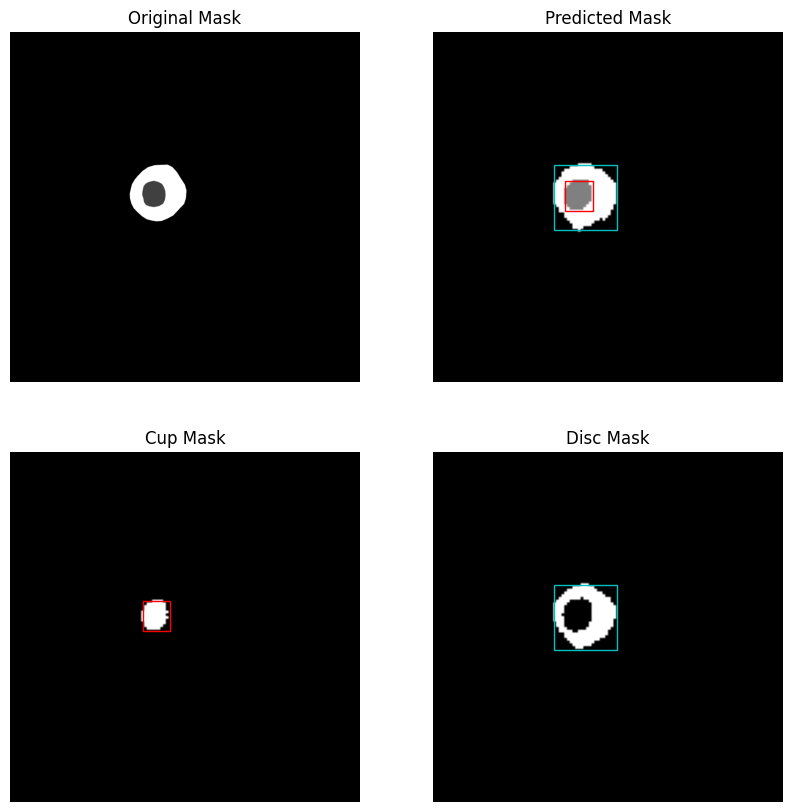

The ID of the image is fff_0_87588_r_1
Here is the CDR from ORIGINAL IMAGE values:
area_cdr: 0.22911051212938005
horizontal_cdr: 0.43478260869565216
vertical_cdr: 0.4583333333333333


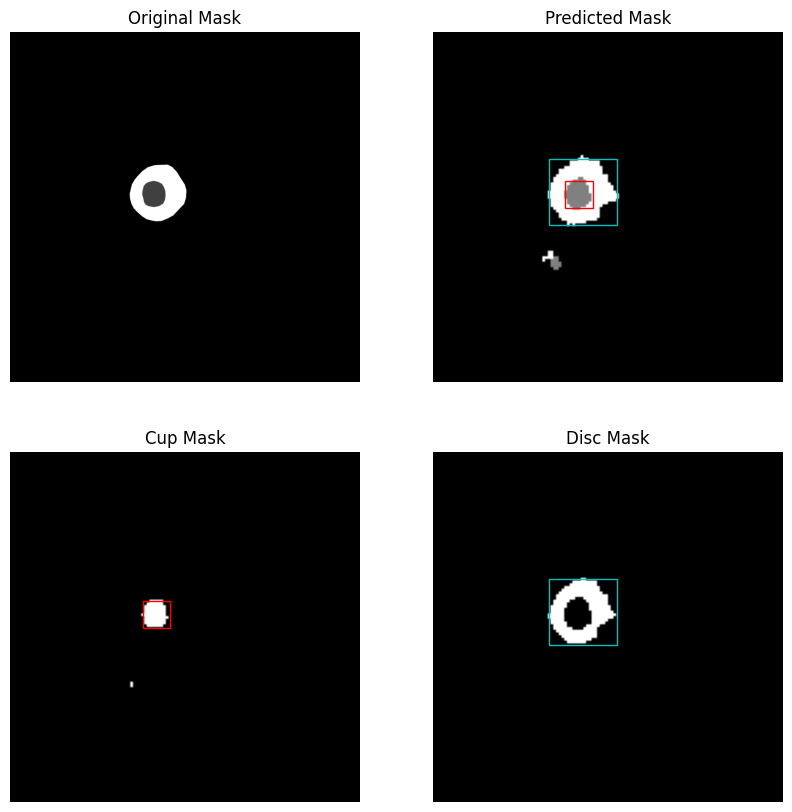

The ID of the image is fff_0_87588_r_1_aug
Here is the CDR from AUGMENTED IMAGE values:
area_cdr: 0.20588235294117646
horizontal_cdr: 0.4
vertical_cdr: 0.4166666666666667


In [54]:
# original image
## visualize the mask image and calculate the CDR
result = utils.ev_cdr(model=model["unet_model_ori"],
                        img_path=test_img_ori.path[rand_idx],
                        mask_path=os.path.join(path_dataset_ori,
                                                f"{test_img_ori.id[rand_idx]}_mask.png"),
                        threshold=threshold,
                        visualize=True)
## show cdr result
print(f"The ID of the image is {test_img_ori.id[rand_idx]}", "Here is the CDR from ORIGINAL IMAGE values:", sep="\n")
for key, value in result.items():
    print(f"{key}: {value}")

# augmented image
## visualize the mask image and calculate the CDR
result = utils.ev_cdr(model=model["unet_model_aug"],
                        img_path=test_img_aug.path[rand_idx],
                        mask_path=os.path.join(path_dataset_aug,
                                                f"{test_img_aug.id[rand_idx].replace('aug', 'mask')}.png"),
                        threshold=threshold,
                        visualize=True)
## show cdr result
print(f"The ID of the image is {test_img_aug.id[rand_idx]}", "Here is the CDR from AUGMENTED IMAGE values:", sep="\n")
for key, value in result.items():
    print(f"{key}: {value}")

#### MobileNet

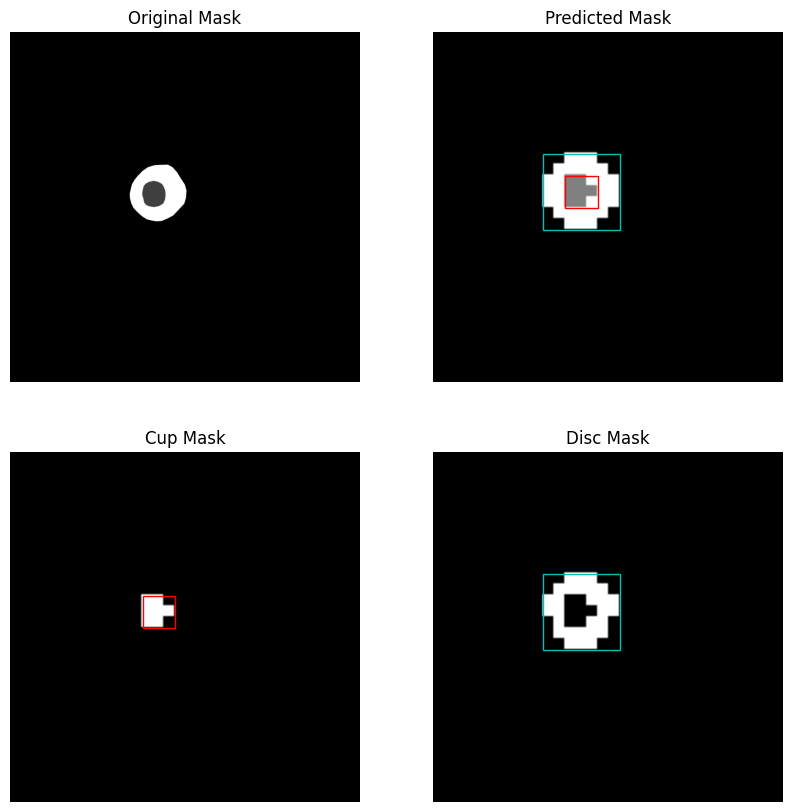

The ID of the image is fff_0_87588_r_1
Here is the CDR from ORIGINAL IMAGE values:
area_cdr: 0.2
horizontal_cdr: 0.42857142857142855
vertical_cdr: 0.42857142857142855


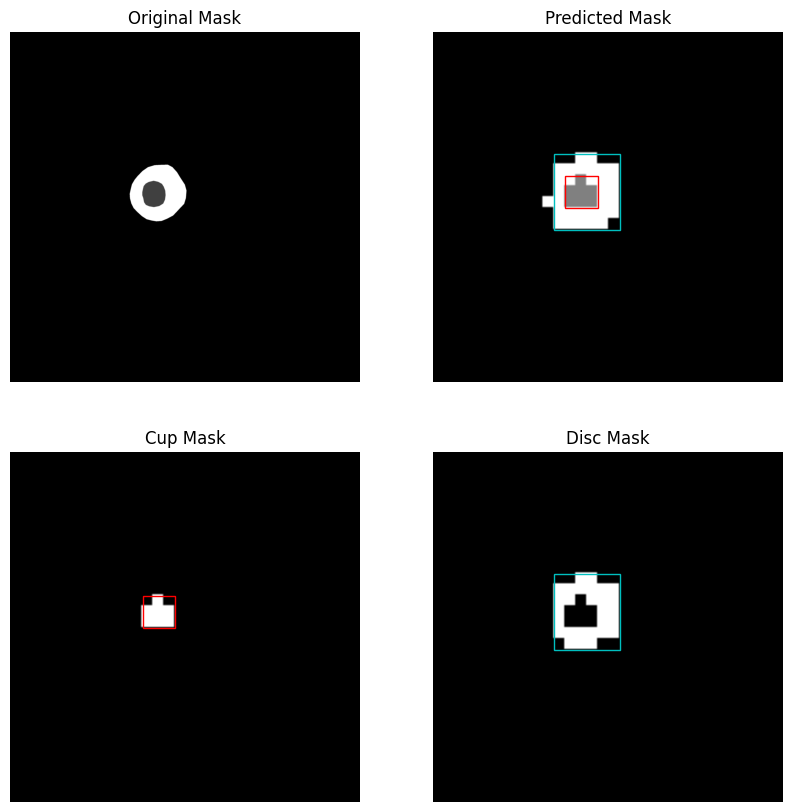

The ID of the image is fff_0_87588_r_1_aug
Here is the CDR from AUGMENTED IMAGE values:
area_cdr: 0.2
horizontal_cdr: 0.5
vertical_cdr: 0.42857142857142855


In [55]:
# original image
## visualize the mask image and calculate the CDR
result = utils.ev_cdr(model=model["mnet_model_ori"],
                        img_path=test_img_ori.path[rand_idx],
                        mask_path=os.path.join(path_dataset_ori,
                                                f"{test_img_ori.id[rand_idx]}_mask.png"),
                        threshold=threshold,
                        visualize=True)
## show cdr result
print(f"The ID of the image is {test_img_ori.id[rand_idx]}", "Here is the CDR from ORIGINAL IMAGE values:", sep="\n")
for key, value in result.items():
    print(f"{key}: {value}")

# augmented image
## visualize the mask image and calculate the CDR
result = utils.ev_cdr(model=model["mnet_model_aug"],
                        img_path=test_img_aug.path[rand_idx],
                        mask_path=os.path.join(path_dataset_aug,
                                                f"{test_img_aug.id[rand_idx].replace('aug', 'mask')}.png"),
                        threshold=threshold,
                        visualize=True)
## show cdr result
print(f"The ID of the image is {test_img_aug.id[rand_idx]}", "Here is the CDR from AUGMENTED IMAGE values:", sep="\n")
for key, value in result.items():
    print(f"{key}: {value}")

#### EfficientNet

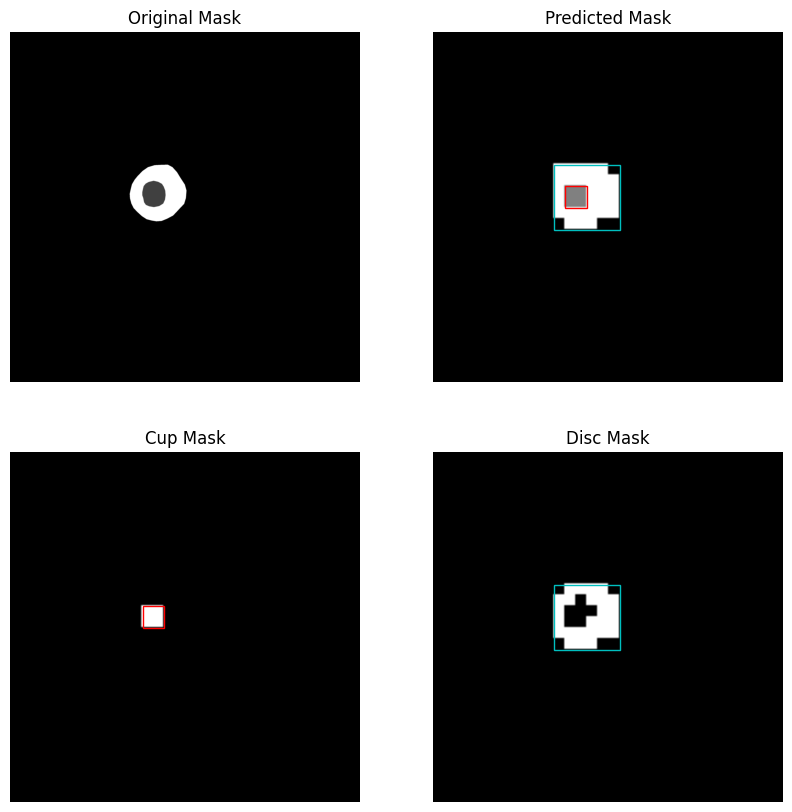

The ID of the image is fff_0_87588_r_1
Here is the CDR from ORIGINAL IMAGE values:
area_cdr: 0.13793103448275862
horizontal_cdr: 0.3333333333333333
vertical_cdr: 0.3333333333333333


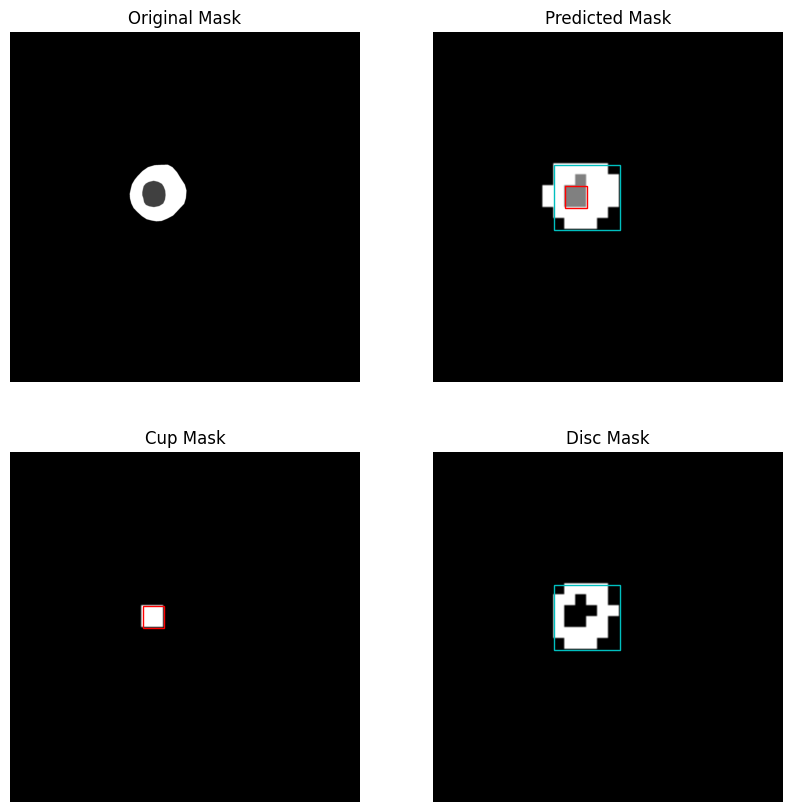

The ID of the image is fff_0_87588_r_1_aug
Here is the CDR from AUGMENTED IMAGE values:
area_cdr: 0.15384615384615385
horizontal_cdr: 0.3333333333333333
vertical_cdr: 0.3333333333333333


In [56]:
# original image
## visualize the mask image and calculate the CDR
result = utils.ev_cdr(model=model["efnet_model_ori"],
                        img_path=test_img_ori.path[rand_idx],
                        mask_path=os.path.join(path_dataset_ori,
                                                f"{test_img_ori.id[rand_idx]}_mask.png"),
                        threshold=threshold,
                        visualize=True)
## show cdr result
print(f"The ID of the image is {test_img_ori.id[rand_idx]}", "Here is the CDR from ORIGINAL IMAGE values:", sep="\n")
for key, value in result.items():
    print(f"{key}: {value}")

# augmented image
## visualize the mask image and calculate the CDR
result = utils.ev_cdr(model=model["efnet_model_aug"],
                        img_path=test_img_aug.path[rand_idx],
                        mask_path=os.path.join(path_dataset_aug,
                                                f"{test_img_aug.id[rand_idx].replace('aug', 'mask')}.png"),
                        threshold=threshold,
                        visualize=True)
## show cdr result
print(f"The ID of the image is {test_img_aug.id[rand_idx]}", "Here is the CDR from AUGMENTED IMAGE values:", sep="\n")
for key, value in result.items():
    print(f"{key}: {value}")

### Get the CDR value from the predicted mask

#### Unet

In [ ]:
# create an empty dataframe to store the results
ev_cdr_unet = {
    "ori": pd.DataFrame(columns=["id", "a_cdr", "v_cdr", "h_cdr"]),
    "aug": pd.DataFrame(columns=["id", "a_cdr", "v_cdr", "h_cdr"])
}

### last update baru sampe sini ko, lanjuting

# get the CDR value for each image
for i, row in test_img.iterrows():
    # get the cdr value
    cdr_value = utils.ev_cdr(model,
                            row.path,
                            os.path.join(path_dataset,
                                        f"{row.id.replace('aug', 'mask')}.png"),
                            .2,)
    # populate the dataframe with the given cdr values
    ev_cdr.loc[i] = [row.id,
                    cdr_value["area_cdr"],
                    cdr_value["vertical_cdr"],
                    cdr_value["horizontal_cdr"]]

# show the data
ev_cdr.head(5)

#### MobileNet

In [ ]:
# create an empty dataframe to store the results
ev_cdr = pd.DataFrame(columns=["id", "a_cdr", "v_cdr", "h_cdr"])

# get the CDR value for each image
for i, row in test_img.iterrows():
    # get the cdr value
    cdr_value = utils.ev_cdr(mobileNet_model,
                            row.path,
                            os.path.join(path_dataset,
                                        f"{row.id.replace('aug', 'mask')}.png"),
                            .2,)
    # populate the dataframe with the given cdr values
    ev_cdr.loc[i] = [row.id,
                    cdr_value["area_cdr"],
                    cdr_value["vertical_cdr"],
                    cdr_value["horizontal_cdr"]]

# show the data
ev_cdr.head(5)

#### EfficientNet

In [ ]:
# create an empty dataframe to store the results
ev_cdr = pd.DataFrame(columns=["id", "a_cdr", "v_cdr", "h_cdr"])

# get the CDR value for each image
for i, row in test_img.iterrows():
    # get the cdr value
    cdr_value = utils.ev_cdr(EfficientNet_model,
                            row.path,
                            os.path.join(path_dataset,
                                        f"{row.id.replace('aug', 'mask')}.png"),
                            .2,)
    # populate the dataframe with the given cdr values
    ev_cdr.loc[i] = [row.id,
                    cdr_value["area_cdr"],
                    cdr_value["vertical_cdr"],
                    cdr_value["horizontal_cdr"]]

# show the data
ev_cdr.head(5)

### Get the Loss of predicted CDR with the dataset CDR

#### Unet

In [ ]:
########## count the loss value ##########
# initialize an empty dictionary to store the results
data = {}
# iterate over the threshold values
for i in np.linspace(.15, .8, 25):
    # round the threshold value to two decimal places
    threshold = round(i, 2)
    print(f"Threshold: {threshold}")
    # create an empty dataframe to store the results
    ev_cdr = pd.DataFrame(columns=["id", "a_cdr", "v_cdr", "h_cdr"])
    # get the CDR value for each image
    for idx, row in test_img.iterrows():
        # get the cdr value
        cdr_value = utils.ev_cdr(model,
                                row.path,
                                os.path.join(path_dataset,
                                            f"{row.id.replace('aug', 'mask')}.png"),
                                threshold,)
        # populate the dataframe with the given cdr values
        ev_cdr.loc[idx] = [row.id,
                        cdr_value["area_cdr"],
                        cdr_value["vertical_cdr"],
                        cdr_value["horizontal_cdr"]]
    # get the loss value
    loss = utils.count_loss_cdr(cdr_data.drop(columns=["label", "eye_side"]),
                                ev_cdr)
    # populate the dictionary with the given threshold and loss value
    data[threshold] = loss

In [ ]:
########## populate the loss dataframe ##########
# create an empty dataframe to store the results
loss_df = pd.DataFrame(columns=['threshold', 'a_mse', 'a_mae', 'a_huber', 'h_mse', 'h_mae', 'h_huber', 'v_mse', 'v_mae', 'v_huber'])
# populate the dataframe with the given loss values
for item, value in data.items():
    loss_df.loc[len(loss_df)] = [item,
                                value['a_mse'],
                                value['a_mae'],
                                value['a_huber'],
                                value['h_mse'],
                                value['h_mae'],
                                value['h_huber'],
                                value['v_mse'],
                                value['v_mae'],
                                value['v_huber']]

# sort the dataframe by the loss value
loss_df.sort_values(by="v_huber", ascending=True, inplace=True)
# loss_df.sort_values(by="a_huber", ascending=True, inplace=True)

# show the data
loss_df

#### mobileNet

In [ ]:
########## count the loss value ##########
# initialize an empty dictionary to store the results
data = {}
# iterate over the threshold values
for i in np.linspace(.15, .8, 25):
    # round the threshold value to two decimal places
    threshold = round(i, 2)
    print(f"Threshold: {threshold}")
    # create an empty dataframe to store the results
    ev_cdr = pd.DataFrame(columns=["id", "a_cdr", "v_cdr", "h_cdr"])
    # get the CDR value for each image
    for idx, row in test_img.iterrows():
        # get the cdr value
        cdr_value = utils.ev_cdr(mobileNet_model,
                                row.path,
                                os.path.join(path_dataset,
                                            f"{row.id.replace('aug', 'mask')}.png"),
                                threshold,)
        # populate the dataframe with the given cdr values
        ev_cdr.loc[idx] = [row.id,
                        cdr_value["area_cdr"],
                        cdr_value["vertical_cdr"],
                        cdr_value["horizontal_cdr"]]
    # get the loss value
    loss = utils.count_loss_cdr(cdr_data.drop(columns=["label", "eye_side"]),
                                ev_cdr)
    # populate the dictionary with the given threshold and loss value
    data[threshold] = loss

In [ ]:
########## populate the loss dataframe ##########
# create an empty dataframe to store the results
loss_df = pd.DataFrame(columns=['threshold', 'a_mse', 'a_mae', 'a_huber', 'h_mse', 'h_mae', 'h_huber', 'v_mse', 'v_mae', 'v_huber'])
# populate the dataframe with the given loss values
for item, value in data.items():
    loss_df.loc[len(loss_df)] = [item,
                                value['a_mse'],
                                value['a_mae'],
                                value['a_huber'],
                                value['h_mse'],
                                value['h_mae'],
                                value['h_huber'],
                                value['v_mse'],
                                value['v_mae'],
                                value['v_huber']]

# sort the dataframe by the loss value
loss_df.sort_values(by="v_huber", ascending=True, inplace=True)
# loss_df.sort_values(by="a_huber", ascending=True, inplace=True)

# show the data
loss_df

#### EfficientNet

In [ ]:
########## count the loss value ##########
# initialize an empty dictionary to store the results
data = {}
# iterate over the threshold values
for i in np.linspace(.15, .8, 25):
    # round the threshold value to two decimal places
    threshold = round(i, 2)
    print(f"Threshold: {threshold}")
    # create an empty dataframe to store the results
    ev_cdr = pd.DataFrame(columns=["id", "a_cdr", "v_cdr", "h_cdr"])
    # get the CDR value for each image
    for idx, row in test_img.iterrows():
        # get the cdr value
        cdr_value = utils.ev_cdr(EfficientNet_model,
                                row.path,
                                os.path.join(path_dataset,
                                            f"{row.id.replace('aug', 'mask')}.png"),
                                threshold,)
        # populate the dataframe with the given cdr values
        ev_cdr.loc[idx] = [row.id,
                        cdr_value["area_cdr"],
                        cdr_value["vertical_cdr"],
                        cdr_value["horizontal_cdr"]]
    # get the loss value
    loss = utils.count_loss_cdr(cdr_data.drop(columns=["label", "eye_side"]),
                                ev_cdr)
    # populate the dictionary with the given threshold and loss value
    data[threshold] = loss

In [ ]:
########## populate the loss dataframe ##########
# create an empty dataframe to store the results
loss_df = pd.DataFrame(columns=['threshold', 'a_mse', 'a_mae', 'a_huber', 'h_mse', 'h_mae', 'h_huber', 'v_mse', 'v_mae', 'v_huber'])
# populate the dataframe with the given loss values
for item, value in data.items():
    loss_df.loc[len(loss_df)] = [item,
                                value['a_mse'],
                                value['a_mae'],
                                value['a_huber'],
                                value['h_mse'],
                                value['h_mae'],
                                value['h_huber'],
                                value['v_mse'],
                                value['v_mae'],
                                value['v_huber']]

# sort the dataframe by the loss value
loss_df.sort_values(by="v_huber", ascending=True, inplace=True)
# loss_df.sort_values(by="a_huber", ascending=True, inplace=True)

# show the data
loss_df

### Get the CDR value with the best treshold

#### Unet

In [ ]:
# create an empty dataframe
ev_cdr = pd.DataFrame(columns=["id", "a_cdr", "v_cdr", "h_cdr"])
# get the CDR value for each image
for idx, row in test_img.iterrows():
    # get the cdr value
    cdr_value = utils.ev_cdr(model,
                            row.path,
                            os.path.join(path_dataset,
                                        f"{row.id.replace('aug', 'mask')}.png"),
                            .64,)   # set the threshold value
    # populate the dataframe with the given cdr values
    ev_cdr.loc[idx] = [row.id,
                    cdr_value["area_cdr"],
                    cdr_value["vertical_cdr"],
                    cdr_value["horizontal_cdr"]]

#### mobileNet

In [ ]:
# create an empty dataframe
ev_cdr = pd.DataFrame(columns=["id", "a_cdr", "v_cdr", "h_cdr"])
# get the CDR value for each image
for idx, row in test_img.iterrows():
    # get the cdr value
    cdr_value = utils.ev_cdr(mobileNet_model,
                            row.path,
                            os.path.join(path_dataset,
                                        f"{row.id.replace('aug', 'mask')}.png"),
                            .64,)   # set the threshold value
    # populate the dataframe with the given cdr values
    ev_cdr.loc[idx] = [row.id,
                    cdr_value["area_cdr"],
                    cdr_value["vertical_cdr"],
                    cdr_value["horizontal_cdr"]]

#### EfficientNet

In [ ]:
# create an empty dataframe
ev_cdr = pd.DataFrame(columns=["id", "a_cdr", "v_cdr", "h_cdr"])
# get the CDR value for each image
for idx, row in test_img.iterrows():
    # get the cdr value
    cdr_value = utils.ev_cdr(EfficientNet_model,
                            row.path,
                            os.path.join(path_dataset,
                                        f"{row.id.replace('aug', 'mask')}.png"),
                            .64,)   # set the threshold value
    # populate the dataframe with the given cdr values
    ev_cdr.loc[idx] = [row.id,
                    cdr_value["area_cdr"],
                    cdr_value["vertical_cdr"],
                    cdr_value["horizontal_cdr"]]

### Get the class from predicted CDR value and real class

In [ ]:
# create an empty dataframe to store the results
test_dataset = pd.DataFrame(columns=list(ev_cdr.columns) + ["real"])

# rename the columns
test_dataset.rename(columns={"a_cdr": "a_class", "v_cdr": "v_class", "h_cdr": "h_class"}, inplace=True)
# get the class by the CDR value and real label
for idx, row in ev_cdr.iterrows():
    test_dataset.loc[idx] = [row.id,
                            1 if row.a_cdr > .5 else 0,
                            1 if row.v_cdr > .5 else 0,
                            1 if row.h_cdr > .5 else 0,
                            row.id.split("_")[1]]

# show the data
test_dataset.head(5)

### Count the accuracy of classification

In [ ]:
# intiate the accuracy metric
acc = tf.keras.metrics.Accuracy()
# count the accuracy
acc.update_state(test_dataset.real.astype(int).values,
                test_dataset.v_class.astype(int).values)
# show the accuracy
print("Accuracy", round(acc.result().numpy(), 2))